<a href="https://colab.research.google.com/github/SaumilShah-7/Scene-Classification/blob/master/Scene_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [75]:
try:
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
print(tf.__version__)

import os
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import seaborn as sns
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras import models, layers
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import binary_crossentropy

2.0.0


In [2]:
from google.colab import files
files.upload()

Saving image_scene_data.zip to image_scene_data.zip


In [0]:
!unzip -q image_scene_data.zip
!rm -rf image_scene_data.zip

In [3]:
df = pd.DataFrame([file for file in os.listdir('original')], columns=['ImageId'])

y_json = pd.read_json('labels.json', lines=True)
y_label_vec = [np.asarray((row==1)*1) for index, row in y_json.iterrows()]

df['Labels_vec'] = df['ImageId'].map(lambda x: y_label_vec[int(str.split(x, '.')[0])-1].tolist())

label_names = ['desert', 'mountains', 'sea', 'sunset', 'trees']
df['Labels'] = df['Labels_vec'].map(lambda x: [label_names[i] for i, j in enumerate(x) if j==1])
df['Classnum'] = df['Labels'].map(lambda x: len(x))
df.head()

,ImageId,Labels_vec,Labels,Classnum
0,207.jpg,"[1, 0, 0, 0, 0]",[desert],1
1,219.jpg,"[1, 0, 0, 0, 0]",[desert],1
2,1952.jpg,"[0, 0, 0, 0, 1]",[trees],1
3,1506.jpg,"[0, 0, 0, 1, 0]",[sunset],1
4,382.jpg,"[1, 0, 0, 0, 0]",[desert],1


**Data exploration**

{'desert': 409, 'mountains': 458, 'sea': 580, 'sunset': 465, 'trees': 560}


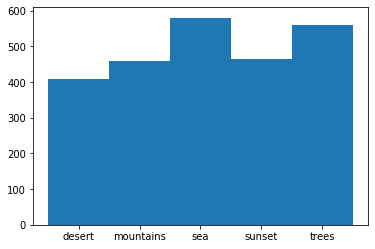

1    1543
2     442
3      15
Name: Classnum, dtype: int64


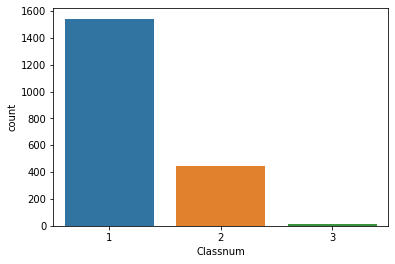

In [4]:
class_summary = np.asarray(y_label_vec).sum(axis=0).tolist()
class_count_dict = {label_names[i]: class_summary[i] for i in range(len(class_summary))}
print(class_count_dict)

xs = np.arange(len(label_names)) 
plt.bar(xs, class_summary, width=1, align='center')
plt.xticks(xs, label_names)
plt.show()

print(df['Classnum'].value_counts())
sns.countplot(df['Classnum'])

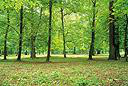

1820.jpg ['trees']


In [5]:
id = 7

from IPython.display import display

img = Image.open('original/'+df.loc[id, 'ImageId'])
display(img)
print(df.loc[id, 'ImageId'], df.loc[id, 'Labels'])

**Stratified split for train / test datasets based on # of classes**

In [95]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=7, stratify=df['Classnum'])
print(train_df.shape, test_df.shape)

(1600, 4) (400, 4)


**Data generators to avoid overfitting**

In [66]:
image_height = 224
image_width = 224

bs = 64
SEED = 7

train_aug_gen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, brightness_range=(0.9, 1.1), zoom_range=0.1, horizontal_flip=True, 
                               preprocessing_function=preprocess_input)

test_aug_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_gen = train_aug_gen.flow_from_dataframe(train_df, directory='original', x_col='ImageId', y_col='Labels', 
                                        target_size=(image_height, image_width), class_mode='categorical', batch_size=bs, seed=SEED)

test_gen = test_aug_gen.flow_from_dataframe(test_df, directory='original', x_col='ImageId', y_col='Labels', 
                                        target_size=(image_height, image_width), class_mode='categorical', batch_size=bs, shuffle=False)

# x_train, y_train = next(train_gen)
# x_test, y_test = next(test_gen)
# print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

# id = 16
# plt.imshow(x_train[id].astype(int))
# plt.show()
# y_train[id]

Found 1600 validated image filenames belonging to 5 classes.
Found 400 validated image filenames belonging to 5 classes.


**Transfer learning using ResNet50**

In [14]:
model = models.Sequential()
model.add(ResNet50(include_top=False, weights='imagenet', input_shape=(image_height, image_width, 3)))
model.add(layers.BatchNormalization())
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(units=100, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(units=5, activation='sigmoid'))
model.layers[0].trainable = False
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
batch_normalization_2 (Batch (None, 7, 7, 2048)        8192      
_________________________________________________________________
flatten_2 (Flatten)          (None, 100352)            0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 100352)            0         
_________________________________________________________________
dense_4 (Dense)              (None, 100)               10035300  
_________________________________________________________________
dropout_5 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 5)                

Epoch 1/10
24/25 [===========================>..] - ETA: 1s - loss: 0.5681 - binary_accuracy: 0.7505
Epoch 00001: val_binary_accuracy improved from -inf to 0.88125, saving model to best_model.h5
25/25 [==============================] - 31s 1s/step - loss: 0.5606 - binary_accuracy: 0.7534 - val_loss: 0.3350 - val_binary_accuracy: 0.8812
Epoch 2/10
24/25 [===========================>..] - ETA: 1s - loss: 0.3485 - binary_accuracy: 0.8582
Epoch 00002: val_binary_accuracy improved from 0.88125 to 0.88802, saving model to best_model.h5
25/25 [==============================] - 29s 1s/step - loss: 0.3458 - binary_accuracy: 0.8594 - val_loss: 0.3161 - val_binary_accuracy: 0.8880
Epoch 3/10
24/25 [===========================>..] - ETA: 1s - loss: 0.2879 - binary_accuracy: 0.8823
Epoch 00003: val_binary_accuracy did not improve from 0.88802
25/25 [==============================] - 28s 1s/step - loss: 0.2871 - binary_accuracy: 0.8827 - val_loss: 0.3077 - val_binary_accuracy: 0.8849
Epoch 4/10
24/2

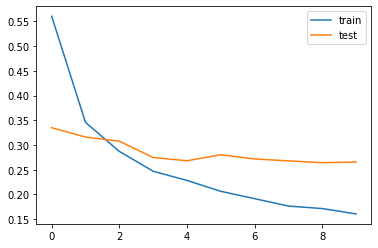

In [15]:
model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['binary_accuracy'])
mc = ModelCheckpoint('best_model.h5', monitor='val_binary_accuracy', mode='max', verbose=1, save_best_only=True)

EPOCH_NUM = 10

history = model.fit_generator(train_gen, steps_per_epoch=train_df.shape[0]//bs, epochs=EPOCH_NUM, callbacks=[mc], 
                              validation_data=test_gen, validation_steps=test_df.shape[0]//bs)

saved_model = models.load_model('best_model.h5')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

**Check for test_df and test_gen order**

In [67]:
_, y_test = next(test_gen)
y_test_n = pd.Series([y_test[i].astype('int') for i in range(y_test.shape[0])])
print([(y_test_n[i] == test_df['Labels_vec'][:64].reset_index(drop=True)[i]).all() for i in range(y_test.shape[0])])

[True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True]


**Truth vs Prediction: Top Losses**

In [99]:
y_test_pred = saved_model.predict(test_gen, steps=(test_df.shape[0]//bs)+1)
test_df['Labels_vec_pred'] = [y_test_pred[i] for i in range(y_test_pred.shape[0])]
test_df = test_df.reset_index(drop=True)
test_df['Labels_pred'] = test_df['Labels_vec_pred'].map(lambda x: [label_names[i] for i, j in enumerate(x) if j > 0.5])
test_df['BCE_Loss'] = [binary_crossentropy(test_df.loc[i, 'Labels_vec'], test_df.loc[i, 'Labels_vec_pred']).numpy() for i in range(test_df.shape[0])]

test_df_r = test_df.sort_values(by='BCE_Loss', ascending=False).reset_index(drop=True)
test_df_r.head()

,ImageId,Labels_vec,Labels,Classnum,Labels_vec_pred,Labels_pred,BCE_Loss
0,120.jpg,"[1, 1, 0, 1, 0]","[desert, mountains, sunset]",3,"[0.00015667081, 0.00048351288, 0.9945592, 0.94...","[sea, sunset]",4.332723
1,387.jpg,"[1, 0, 0, 0, 0]",[desert],1,"[0.0007991791, 0.0001693964, 0.0053810775, 0.9...","[sunset, trees]",3.508662
2,688.jpg,"[0, 1, 0, 0, 0]",[mountains],1,"[0.0016696155, 0.012465924, 0.9986851, 0.13450...",[sea],2.242935
3,102.jpg,"[1, 1, 0, 0, 0]","[desert, mountains]",2,"[0.0073639452, 0.05192116, 0.5954428, 0.888434...","[sea, sunset]",2.206303
4,105.jpg,"[1, 0, 0, 0, 0]",[desert],1,"[0.015143186, 0.3316424, 0.16898707, 0.9977295...",[sunset],2.174585


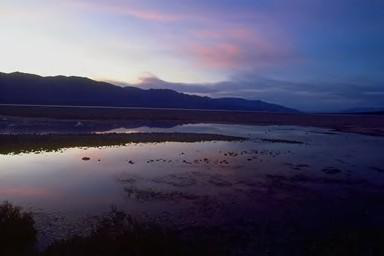

102.jpg ['desert', 'mountains'] ['sea', 'sunset']


In [104]:
id = 3
img = Image.open('original/'+test_df_r.loc[id, 'ImageId'])
display(img)
print(test_df_r.loc[id, 'ImageId'], test_df_r.loc[id, 'Labels'], test_df_r.loc[id, 'Labels_pred'])